# Network IO Processor

The Network IO Processor (IOP) enables raw access to the Ethernet interface from within Python.
The usage is similar in many ways to sending and receiving Ethernet frames using raw sockets.

The advantages of this access include:
1. Packets can be sent with low-latency, bypassing the normal Linux kernel stack.
2. Access to the network interface is memory-mapped, enabling network-connected accelerators
   to be prototyped on the ARM cores and then migrated into the Programmable Logic (PL).


## 1. Downloading overlay
Now let's download the overlay and do necessary configurations.

In [1]:
from pynq_networking import MqttsnOverlay
from site import getsitepackages
import os

mqttsn_bit = os.path.join(getsitepackages()[0], 'pynq_networking',
                          'overlays', 'mqttsn', 'mqttsn.bit')
overlay = MqttsnOverlay(mqttsn_bit)
overlay.download()

/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:299: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


In [2]:
import timeit
import logging
logging.getLogger("kamene.runtime").setLevel(logging.ERROR)
from kamene.all import *
from wurlitzer import sys_pipes
from pynq_networking.lib.network_iop import NetworkIOP
from pynq_networking.lib.slurper import PacketSlurper
from pynq_networking.lib.pynqsocket import L2PynqSocket

conf.L2PynqSocket = L2PynqSocket

## 3. Bring up interfaces and modules
We can bring up a network interface for testing. 
For hardware acceleration, we need to inject the Linux kernel driver.

The Python class `LinkManager` is a wrapper for the following commands:
```csh
chmod 777 ./kernel_module/*.sh
ifconfig br0:1 192.168.3.99
ifconfig br0:0 192.168.1.99
./kernel_module/link_up.sh
```

In [3]:
from pynq_networking import LinkManager

if_manager = LinkManager()
if_manager.if_up("br0:1", "192.168.3.99")
if_manager.if_up("br0:0", "192.168.1.99")
if_manager.kernel_up()

The kernel module only needs to be run 1 time after the 
board has been booted.

In [4]:
mynet = NetworkIOP()
conf.L2PynqSocket().flush()

156 packets flushed


## 4. Measuring performance
We can do a bit of research here. Let's find out how fast we can push out 
packets first, as shown below.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import PL
from pynq import MMIO
from pynq_networking import *

sizes = [64, 128, 256, 512, 1024, 1500]
count = 500
pps = []
bps = []
usperpacket = []
cyclesperword = []
theoretical = []
mmio = MMIO(0xFFFC0000, 0x10000)

my_ip_str = '192.168.1.104'
my_mac_str = '8a:70:bd:29:2b:40'

for size in sizes:
    payload = b''.join([b'0' for _ in range(size)])
    frame = Ether(src=my_mac_str, dst='FF:FF:FF:FF:FF:FF')/\
        IP(src=my_ip_str, dst="192.168.1.2")/\
        UDP(sport=50000, dport=1884)/MQTTSN()/MQTTSN_CONNECT()
    frame = bytes(frame) + payload
    slurper = conf.L2PynqSocket().slurper
    kameneSocket = conf.L2socket()
    write32 = slurper.write32
    array = slurper.mmio.array
    mem = slurper.mmio.mem
    leng = len(frame)

    start_time = timeit.default_timer()
    for _ in range(count):
        frame_bytes = bytes(frame)
        slurper.send(frame_bytes)
    elapsed = timeit.default_timer() - start_time

    bps.append(count*len(frame)*8/elapsed)
    pps.append(count/elapsed)
    usperpacket.append(1000000/(count/elapsed))
    cyclesperword.append((100000000*elapsed)/(count*(len(frame)/4)))
    theoretical.append(100000000/(len(frame)/4))

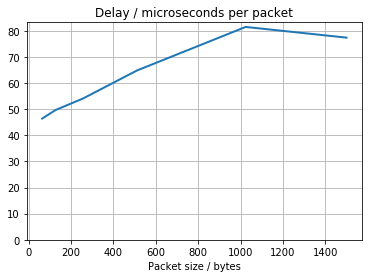

In [6]:
plt.title("Delay / microseconds per packet")
plt.plot(sizes, usperpacket, linewidth=2.0)
plt.ylim(ymin=0)
plt.xlabel('Packet size / bytes')
plt.grid(True)
plt.show()

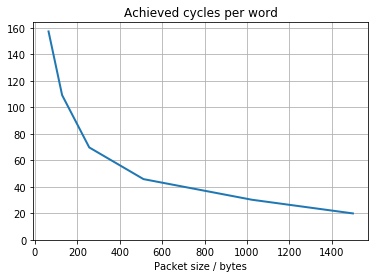

In [7]:
plt.title("Achieved cycles per word")
plt.plot(sizes, cyclesperword, linewidth=2.0)
plt.ylim(ymin=0)
plt.xlabel('Packet size / bytes')
plt.grid(True)
plt.show()

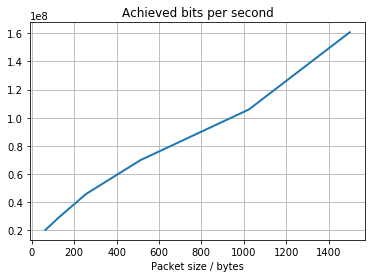

In [8]:
plt.title("Achieved bits per second")
plt.plot(sizes, bps, linewidth=2.0)
plt.xlabel('Packet size / bytes')
plt.grid(True)
plt.show()

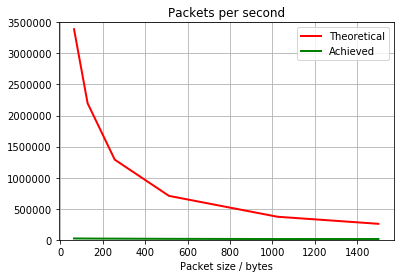

In [9]:
plt.title("Packets per second")
plot0, = plt.plot(sizes, theoretical, label='Theoretical',
                  linewidth=2.0, color='red')
plot1, = plt.plot(sizes, pps, label='Achieved', 
                  linewidth=2.0, color='green')
plt.legend(handles=[plot0, plot1])
plt.ylim(ymin=0, ymax=3500000)
plt.xlabel('Packet size / bytes')
plt.grid(True)
plt.show()

## 5. Cleanup
We can remove the kernel module and close the interfaces in the end.

In [10]:
if_manager.kernel_down()
if_manager.if_down('br0:0')
if_manager.if_down('br0:1')